In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 


import numpy as np


from sklearn.model_selection import train_test_split
import category_encoders as ce
import scipy.stats as stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  RobustScaler, FunctionTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV






%matplotlib inline

### Now I will work with the dataset, where I tried to keep maximally the data:

In [29]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")




# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year', 'offer_description', ])

df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')


In [ ]:
df.info()

In [4]:
# Splitting the data into training and test sets
X = df.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df['price_in_euro']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### GridSearchCV performs an exhaustive search over a predefined hyperparameter grid. For each combination of hyperparameters, it runs cross-validation and returns the best combination based on a performance metric (e.g., accuracy, R², RMSE).

In [5]:

# Define custom transformations
log_transformer = FunctionTransformer(np.log1p, validate=True)  # Log(x + 1) to avoid log(0) issue
sqrt_transformer = FunctionTransformer(np.sqrt, validate=True)

# List of columns to apply transformations
log_columns = ['age', 'power_ps', 'Modell_encoded', 'Brand_encoded', 'fuel_consumption_l_100km']  # Columns that need log transformation
sqrt_columns = ['mileage_in_km']  # Square root transformation for mileage
robust_columns = ['age', 'power_ps', 'Modell_encoded', 'Brand_encoded', 'fuel_consumption_l_100km', 'mileage_in_km']  # Robust scaling for K-NN (price included)

# Preprocessing pipelines for specific models
knn_preprocessor = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), robust_columns)
    ], remainder='passthrough')

linreg_preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', log_transformer, log_columns),
        ('sqrt_transform', sqrt_transformer, sqrt_columns)
    ], remainder='passthrough')

# For Random Forest and Decision Tree, we can skip preprocessing


# Define the full pipeline with different models
pipeline = Pipeline([
    ('preprocessor', 'passthrough'),  # Placeholder for model-specific preprocessing
    ('regressor', RandomForestRegressor())  # Placeholder for the model
])

# Set up the parameter grid with model-specific preprocessing pipelines
param_grid = [
    {
        'preprocessor': [linreg_preprocessor],
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False],
    },
    {
        'preprocessor': [knn_preprocessor],
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': [3, 5, 7],
    },
    {
        'preprocessor': ['passthrough'],  # No preprocessing for Random Forest
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
    },
    {
        'preprocessor': ['passthrough'],  # No preprocessing for Decision Tree
        'regressor': [DecisionTreeRegressor()],
        'regressor__max_depth': [10, 20, None],
    },
     {
        'preprocessor': ['passthrough'],  # No preprocessing for XGBoost
        'regressor': [XGBRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [5, 10, 15],
        'regressor__learning_rate': [0.01, 0.1, 0.3],
        'regressor__subsample': [0.8, 1.0],
    }
]

# Perform GridSearchCV over the pipeline with different models and preprocessing
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Find the best model and hyperparameters
print("Best model and hyperparameters: ", grid_search.best_params_)

/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model and hyperparameters:  {'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('robust_scaler', RobustScaler(),
                                 ['age', 'power_ps', 'Modell_encoded',
                                  'Brand_encoded', 'fuel_consumption_l_100km',
                                  'mileage_in_km'])]), 'regressor': KNeighborsRegressor(n_neighbors=3), 'regressor__n_neighbors': 3}


In [6]:
# Get the best cross-validated score (MSE or whatever scoring metric you used)
best_cv_score = grid_search.best_score_
print(f"Best Cross-Validated Score (neg_mean_squared_error): {best_cv_score}")

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters: ", best_params)

Best Cross-Validated Score (neg_mean_squared_error): 0.803790824557552
Best Hyperparameters:  {'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('robust_scaler', RobustScaler(),
                                 ['age', 'power_ps', 'Modell_encoded',
                                  'Brand_encoded', 'fuel_consumption_l_100km',
                                  'mileage_in_km'])]), 'regressor': KNeighborsRegressor(n_neighbors=3), 'regressor__n_neighbors': 3}


In [7]:
# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate various metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f"Test Set MSE: {mse_test}")
print(f"Test Set MAE: {mae_test}")
print(f"Test Set R²: {r2_test}")

Test Set MSE: 172252763.7921711
Test Set MAE: 4110.790905212508
Test Set R²: 0.8479450427323951


In [8]:
# Get all the results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Display the entire results DataFrame
#print(results)

# If you want to sort by mean test score for better visibility
sorted_results = results.sort_values(by='mean_test_score', ascending=False)
sorted_results[['param_regressor', 'param_regressor__fit_intercept', 
                      'param_regressor__n_neighbors', 'param_regressor__n_estimators', 
                      'param_regressor__max_depth', 'mean_test_score']]

,param_regressor,param_regressor__fit_intercept,param_regressor__n_neighbors,param_regressor__n_estimators,param_regressor__max_depth,mean_test_score
2,KNeighborsRegressor(n_neighbors=3),NaN,3,NaN,NaN,0.803791
3,KNeighborsRegressor(n_neighbors=3),NaN,5,NaN,NaN,0.788368
9,RandomForestRegressor(),NaN,NaN,100,None,0.787312
7,RandomForestRegressor(),NaN,NaN,100,20,0.784188
10,RandomForestRegressor(),NaN,NaN,200,None,0.784003
8,RandomForestRegressor(),NaN,NaN,200,20,0.783685
6,RandomForestRegressor(),NaN,NaN,200,10,0.778606
4,KNeighborsRegressor(n_neighbors=3),NaN,7,NaN,NaN,0.775035
5,RandomForestRegressor(),NaN,NaN,100,10,0.771960
28,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,5,0.763588


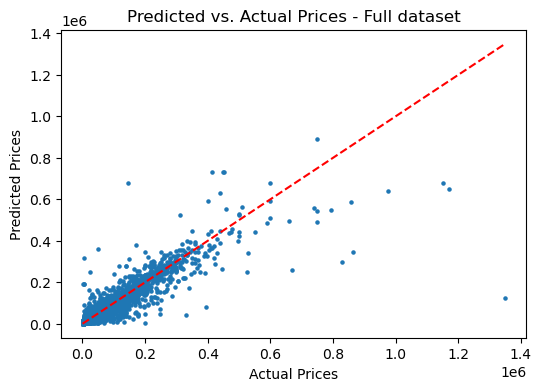

In [9]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, s=5)  # Correctly plot inverse transformed values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices - Full dataset')
plt.show()

## In the next I will transformed the target variable -  price:

In [10]:
# Splitting the data into training and test sets
X = df.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df['price_in_euro']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define custom transformations
log_transformer = FunctionTransformer(np.log1p, validate=True)  # Log(x + 1) to avoid log(0) issue
sqrt_transformer = FunctionTransformer(np.sqrt, validate=True)

# List of columns to apply transformations
log_columns = ['age', 'power_ps', 'Modell_encoded', 'Brand_encoded', 'fuel_consumption_l_100km']  # Columns that need log transformation
sqrt_columns = ['mileage_in_km']  # Square root transformation for mileage
robust_columns = ['age', 'power_ps', 'Modell_encoded', 'Brand_encoded', 'fuel_consumption_l_100km', 'mileage_in_km']  # Robust scaling for K-NN (price included)

# Preprocessing pipelines for specific models
knn_preprocessor = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), robust_columns)
    ], remainder='passthrough')

linreg_preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', log_transformer, log_columns),
        ('sqrt_transform', sqrt_transformer, sqrt_columns)
    ], remainder='passthrough')

# For Random Forest and Decision Tree, we can skip preprocessing


# Define the full pipeline with different models
pipeline = Pipeline([
    ('preprocessor', 'passthrough'),  # Placeholder for model-specific preprocessing
    ('regressor', RandomForestRegressor())  # Placeholder for the model
])

# Set up the parameter grid with model-specific preprocessing pipelines
param_grid = [
    {
        'preprocessor': [linreg_preprocessor],
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False],
    },
    {
        'preprocessor': [knn_preprocessor],
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': [3, 5, 7],
    },
    {
        'preprocessor': ['passthrough'],  # No preprocessing for Random Forest
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
    },
    {
        'preprocessor': ['passthrough'],  # No preprocessing for Decision Tree
        'regressor': [DecisionTreeRegressor()],
        'regressor__max_depth': [10, 20, None],
    },
     {
        'preprocessor': ['passthrough'],  # No preprocessing for XGBoost
        'regressor': [XGBRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [5, 10, 15],
        'regressor__learning_rate': [0.01, 0.1, 0.3],
        'regressor__subsample': [0.8, 1.0],
    }
    
]
# Transform 'y' (price_in_euro) separately using np.log1p
y_train_transformed = np.log1p(y_train)
y_test_transformed = np.log1p(y_test)
# Perform GridSearchCV over the pipeline with different models and preprocessing
grid_search_2 = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_2.fit(X_train, y_train_transformed)

# Find the best model and hyperparameters
print("Best model and hyperparameters: ", grid_search_2.best_params_)

/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model and hyperparameters:  {'preprocessor': 'passthrough', 'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 200, 'regressor__subsample': 1.0}


In [11]:
# Get the best cross-validated score (MSE or whatever scoring metric you used)
best_cv_score_2 = grid_search_2.best_score_
print(f"Best Cross-Validated Score (neg_mean_squared_error): {best_cv_score_2}")

# Get the best hyperparameters and model
best_params_2 = grid_search_2.best_params_
best_model_2 = grid_search_2.best_estimator_

print("Best Hyperparameters: ", best_params_2)

Best Cross-Validated Score (neg_mean_squared_error): 0.9284116443152979
Best Hyperparameters:  {'preprocessor': 'passthrough', 'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 200, 'regressor__subsample':

In [12]:
# Predict on the test set
y_pred = best_model_2.predict(X_test)

# Calculate various metrics


mse_test_2 = mean_squared_error(y_test_transformed, y_pred)
mae_test_2 = mean_absolute_error(y_test_transformed, y_pred)
r2_test_2 = r2_score(y_test_transformed, y_pred)

print(f"Test Set MSE: {mse_test_2}")
print(f"Test Set MAE: {mae_test_2}")
print(f"Test Set R²: {r2_test_2}")

Test Set MSE: 0.05033927221908408
Test Set MAE: 0.13668619939498447
Test Set R²: 0.9309398820279883


In [13]:
# Perform inverse log transformation on both predicted and actual prices
y_test_inv = np.exp(y_test_transformed) - 1  # Inverse log transform for actual test values
y_pred_inv = np.exp(y_pred) - 1  # Inverse log transform for predicted values

In [14]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual Price': np.exp(y_test_transformed) - 1,  # Inverse log transform for actual values
    'Predicted Price': y_pred_inv,       # Inversely transformed predicted prices
    'Modell_encoded': X_test['Modell_encoded'],# Not transformed 'Modell_encoded'
    'Year': 2024 - X_test['age'],    # Compute the actual year
    'Fuel_consum': X_test['fuel_consumption_l_100km'],  # Inversely transformed fuel consumption
    'Power_ps': X_test['power_ps']   # Inversely transformed power in PS
})

# Step 5: Extract the original 'model' names from the original df
models_df = df[['Modell_encoded', 'model']].drop_duplicates()  # Ensure unique Modell_encoded values

# Merge the comparison DataFrame with models_df based on 'Modell_encoded'
comparison_df = pd.merge(comparison_df, models_df, on='Modell_encoded', how='left')


In [15]:
comparison_df.head(20)

,Actual Price,Predicted Price,Modell_encoded,Year,Fuel_consum,Power_ps,model
0,31190.0,32176.925781,26721.409554,2023.0,6.8,150.0,Hyundai TUCSON
1,16800.0,17418.949219,22105.985007,2007.0,9.5,250.0,Audi TT
2,7500.0,6387.243652,13648.615079,2013.0,4.5,82.0,Citroen C3
3,14490.0,14337.623047,11266.490635,2020.0,5.9,75.0,Opel Corsa
4,15870.0,16582.597656,15719.232170,2020.0,5.4,95.0,SEAT Ibiza
5,13990.0,17967.033203,23339.566867,2017.0,5.2,120.0,Ford Kuga
6,49699.0,44461.277344,32593.795782,2022.0,5.9,150.0,Volkswagen T6.1 Kombi
7,29900.0,31101.402344,41840.969250,2019.0,5.4,150.0,Land Rover Range Rover Evoque
8,34888.0,28673.525391,21549.245399,2017.0,6.1,258.0,Mercedes-Benz E 350
9,21489.0,20827.976562,13707.461640,2023.0,5.0,101.0,Hyundai i20


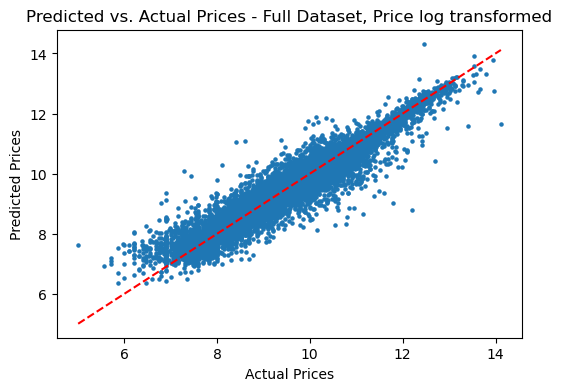

In [17]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test_transformed, y_pred, s=5)  # Correctly plot inverse transformed values
plt.plot([min(y_test_transformed), max(y_test_transformed)], [min(y_test_transformed), max(y_test_transformed)], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices - Full Dataset, Price log transformed')
plt.show()

In [18]:
# Get all the results into a DataFrame
results_2 = pd.DataFrame(grid_search_2.cv_results_)

# Display the entire results DataFrame
#print(results)

# If you want to sort by mean test score for better visibility
sorted_results_2 = results_2.sort_values(by='mean_test_score', ascending=False)
sorted_results_2[['param_regressor', 'param_regressor__fit_intercept', 
                      'param_regressor__n_neighbors', 'param_regressor__n_estimators', 
                      'param_regressor__max_depth', 'mean_test_score']]

,param_regressor,param_regressor__fit_intercept,param_regressor__n_neighbors,param_regressor__n_estimators,param_regressor__max_depth,mean_test_score
33,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,10,0.928412
32,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,10,0.928195
30,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,100,10,0.928123
31,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,100,10,0.927941
41,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,5,0.925606
40,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,5,0.924413
43,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,100,10,0.924270
8,RandomForestRegressor(),NaN,NaN,200,20,0.923067
34,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,100,15,0.922880
7,RandomForestRegressor(),NaN,NaN,100,20,0.922665


In [19]:
# Predict on the test set
y_pred_transformed = best_model_2.predict(X_test)

# Inverse log transformation on both actual and predicted values
y_test_inv = np.expm1(y_test_transformed)  # Use expm1 for e^x - 1
y_pred_inv = np.expm1(y_pred_transformed)  # Same inverse for predictions

# Calculate metrics on the original scale
mse_test_2 = mean_squared_error(y_test_inv, y_pred_inv)
mae_test_2 = mean_absolute_error(y_test_inv, y_pred_inv)
r2_test_2 = r2_score(y_test_inv, y_pred_inv)

print(f"Test Set MSE: {mse_test_2}")
print(f"Test Set MAE: {mae_test_2}")
print(f"Test Set R²: {r2_test_2}")


Test Set MSE: 184775628.8985262
Test Set MAE: 3264.6105239095637
Test Set R²: 0.8368905686171801


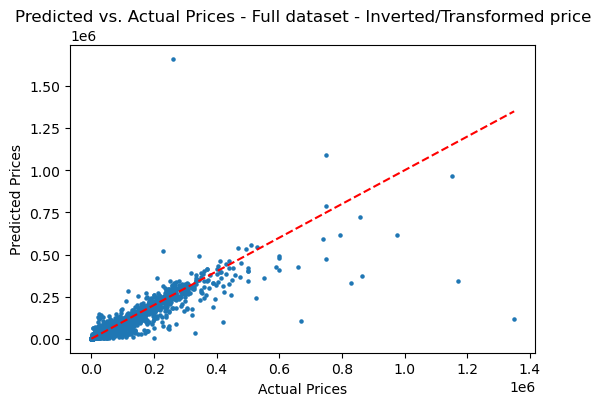

In [21]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test_inv, y_pred_inv, s=5)  # Correctly plot inverse transformed values
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices - Full dataset - Inverted/Transformed price')
plt.show()

## What I learned from here: I transformed the target, and got nice metrics, but if I invert it back, the metrics changes as well.

## The differences in metrics that I am observing, especially the initial ones when comparing log-transformed versus inverse-transformed values, can be quite common in regression tasks, particularly with skewed data and transformations like logarithmic scaling. Here’s a deeper look into why I might see such differences and whether they’re normal:

1. Impact of Log Transformation on Metrics
When I apply a log transformation to my target variable:

Scale Change: The scale of the predictions changes. Log transformation compresses the values, especially when the target variable has a wide range (as prices often do).
Variance Reduction: The log transformation can reduce variance in my data, making it easier for the model to capture relationships. However, when you inverse transform the predictions back, the original variance is restored, which can lead to larger errors.

2. Inversion and Interpretation of Predictions
When I inverse the transformation:

Inaccuracy in Predictions: The inverse transformation, particularly for predictions made on log-transformed data, can lead to inaccuracies due to the way logarithms behave. Small errors in the log scale can lead to larger errors when transformed back to the original scale.
For example, predicting a log value of 3.0 (which corresponds to a target value of approximately 19.09) versus predicting a log value of 3.1 (which corresponds to approximately 22.17) demonstrates that even a small difference in the log scale can lead to a relatively large difference in the original scale.

3. Comparing Log-transformed and Original Scale Metrics
When evaluating my model:

Direct Comparisons: It's not unusual for metrics calculated on transformed and untransformed scales to differ significantly. This happens because:
Mean Squared Error (MSE) and Mean Absolute Error (MAE) scale differently depending on whether you’re looking at log-transformed values or the original values.
The metrics from the transformed scale often look "better" because they reflect the model's performance on a scale that reduces the influence of outliers and compresses the range of predictions.

4. Normalizing Metrics Between Scales
To get a better grasp of model performance:

Always Inverse Transform: Ensure you are calculating all metrics on the same scale. When you inverse transform your predictions and actual values, you should see a change in metrics that could reflect the inherent difficulties in predicting skewed data.


## Next approach in my pipeline is to remove outliers in price and in mileage (because they are the most skewed data in my dataset)

In [5]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable
# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['registration_date','year', 'power_kw', 'offer_description', ])
df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')

# Remove outliers using Z-score for price and mileage
df_clean = df[(np.abs(stats.zscore(df['price_in_euro'])) < 4)]  # 3 is the standard threshold for outliersb
df_clean = df_clean[(np.abs(stats.zscore(df_clean['mileage_in_km'])) < 4)]  # Do the same for mi


X = df_clean.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df_clean['price_in_euro']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
df_clean['price_in_euro'].describe()

count    235874.00000
mean      23509.09837
std       19308.39577
min         120.00000
25%       11800.00000
50%       19390.00000
75%       28999.00000
max      171290.00000
Name: price_in_euro, dtype: float64

In [8]:
# Define custom transformations
log_transformer = FunctionTransformer(np.log1p, validate=True)  # Log(x + 1) to avoid log(0) issue
sqrt_transformer = FunctionTransformer(np.sqrt, validate=True)

# List of columns to apply transformations
log_columns = ['age', 'power_ps', 'Modell_encoded', 'Brand_encoded', 'fuel_consumption_l_100km']  # Columns that need log transformation
sqrt_columns = ['mileage_in_km']  # Square root transformation for mileage
robust_columns = ['age', 'power_ps', 'Modell_encoded', 'Brand_encoded', 'fuel_consumption_l_100km', 'mileage_in_km']  # Robust scaling for K-NN (price included)

# Preprocessing pipelines for specific models
knn_preprocessor = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), robust_columns)
    ], remainder='passthrough')

linreg_preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', log_transformer, log_columns),
        ('sqrt_transform', sqrt_transformer, sqrt_columns)
    ], remainder='passthrough')

# For Random Forest and Decision Tree, we can skip preprocessing


# Define the full pipeline with different models
pipeline = Pipeline([
    ('preprocessor', 'passthrough'),  # Placeholder for model-specific preprocessing
    ('regressor', RandomForestRegressor())  # Placeholder for the model
])

# Set up the parameter grid with model-specific preprocessing pipelines
param_grid = [
    {
        'preprocessor': [linreg_preprocessor],
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False],
    },
    {
        'preprocessor': [knn_preprocessor],
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': [3, 5, 7],
    },
    {
        'preprocessor': ['passthrough'],  # No preprocessing for Random Forest
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
    },
    {
        'preprocessor': ['passthrough'],  # No preprocessing for Decision Tree
        'regressor': [DecisionTreeRegressor()],
        'regressor__max_depth': [10, 20, None],
    },
     {
        'preprocessor': ['passthrough'],  # No preprocessing for XGBoost
        'regressor': [XGBRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [5, 10, 15],
        'regressor__learning_rate': [0.01, 0.1, 0.3],
        'regressor__subsample': [0.8, 1.0],
    }
]

# Perform GridSearchCV over the pipeline with different models and preprocessing
grid_search_3 = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_3.fit(X_train, y_train)

# Find the best model and hyperparameters
print("Best model and hyperparameters: ", grid_search_3.best_params_)

/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model and hyperparameters:  {'preprocessor': 'passthrough', 'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}


In [9]:
# Get the best cross-validated score (MSE or whatever scoring metric you used)
best_cv_score_3 = grid_search_3.best_score_
print(f"Best Cross-Validated Score (r2 score): {best_cv_score_3}")

# Get the best hyperparameters and model
best_params_3 = grid_search_3.best_params_
best_model_3 = grid_search_3.best_estimator_

print("Best Hyperparameters: ", best_params_3)

Best Cross-Validated Score (r2 score): 0.9107453566659295
Best Hyperparameters:  {'preprocessor': 'passthrough', 'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}


In [10]:
# Predict on the test set
y_pred = best_model_3.predict(X_test)


mse_test_3 = mean_squared_error(y_test, y_pred)
mae_test_3 = mean_absolute_error(y_test, y_pred)
r2_test_3 = r2_score(y_test, y_pred)

print(f"Test Set MSE: {mse_test_3}")
print(f"Test Set MAE: {mae_test_3}")
print(f"Test Set R²: {r2_test_3}")

Test Set MSE: 33357651.201427784
Test Set MAE: 2797.339790148389
Test Set R²: 0.9097454240961115


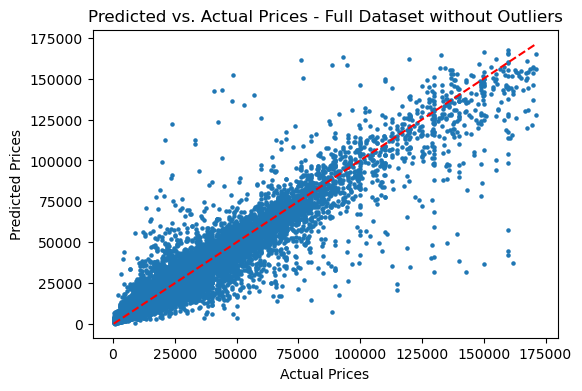

In [11]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, s=5)  # Correctly plot inverse transformed values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices - Full Dataset without Outliers')
plt.show()

In [12]:
# Get all the results into a DataFrame
results_3 = pd.DataFrame(grid_search_3.cv_results_)

# Display the entire results DataFrame
#print(results)

# If you want to sort by mean test score for better visibility
sorted_results_3 = results_3.sort_values(by='mean_test_score', ascending=False)
sorted_results_3[['param_regressor', 'param_regressor__fit_intercept', 
                      'param_regressor__n_neighbors', 'param_regressor__n_estimators', 
                      'param_regressor__max_depth', 'mean_test_score']]

,param_regressor,param_regressor__fit_intercept,param_regressor__n_neighbors,param_regressor__n_estimators,param_regressor__max_depth,mean_test_score
32,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,10,0.910745
30,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,100,10,0.910514
33,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,10,0.910220
31,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,100,10,0.909869
41,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,5,0.907465
8,RandomForestRegressor(),NaN,NaN,200,20,0.907291
7,RandomForestRegressor(),NaN,NaN,100,20,0.907071
10,RandomForestRegressor(),NaN,NaN,200,None,0.906782
9,RandomForestRegressor(),NaN,NaN,100,None,0.906284
40,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,5,0.905902


## Now I will use the version of dataset; where I dropped the strange data. Let's see:

In [19]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_drop__15_10_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['registration_date','year', 'power_kw', 'offer_description'])

df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213736 entries, 0 to 213735
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   brand                             213736 non-null  object 
 1   model                             213736 non-null  object 
 2   price_in_euro                     213736 non-null  float64
 3   power_ps                          213736 non-null  float64
 4   fuel_consumption_l_100km          213736 non-null  float64
 5   mileage_in_km                     213736 non-null  float64
 6   age                               213736 non-null  float64
 7   Modell_encoded                    213736 non-null  float64
 8   Brand_encoded                     213736 non-null  float64
 9   fuel_type_CNG                     213736 non-null  int64  
 10  fuel_type_Diesel                  213736 non-null  int64  
 11  fuel_type_Diesel Hybrid           213736 non-null  i

In [30]:
X = df.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df['price_in_euro']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Define custom transformations
log_transformer = FunctionTransformer(np.log1p, validate=True)  # Log(x + 1) to avoid log(0) issue
sqrt_transformer = FunctionTransformer(np.sqrt, validate=True)

# List of columns to apply transformations
log_columns = ['age', 'power_ps', 'Modell_encoded', 'Brand_encoded', 'fuel_consumption_l_100km']  # Columns that need log transformation
sqrt_columns = ['mileage_in_km']  # Square root transformation for mileage
robust_columns = ['age', 'power_ps', 'Modell_encoded', 'Brand_encoded', 'fuel_consumption_l_100km', 'mileage_in_km']  # Robust scaling for K-NN (price included)

# Preprocessing pipelines for specific models
knn_preprocessor = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), robust_columns)
    ], remainder='passthrough')

linreg_preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', log_transformer, log_columns),
        ('sqrt_transform', sqrt_transformer, sqrt_columns)
    ], remainder='passthrough')

# For Random Forest and Decision Tree, we can skip preprocessing


# Define the full pipeline with different models
pipeline = Pipeline([
    ('preprocessor', 'passthrough'),  # Placeholder for model-specific preprocessing
    ('regressor', RandomForestRegressor())  # Placeholder for the model
])

# Set up the parameter grid with model-specific preprocessing pipelines
param_grid = [
    {
        'preprocessor': [linreg_preprocessor],
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False],
    },
    {
        'preprocessor': [knn_preprocessor],
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': [3, 5, 7],
    },
    {
        'preprocessor': ['passthrough'],  # No preprocessing for Random Forest
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
    },
    {
        'preprocessor': ['passthrough'],  # No preprocessing for Decision Tree
        'regressor': [DecisionTreeRegressor()],
        'regressor__max_depth': [10, 20, None],
    },
     {
        'preprocessor': ['passthrough'],  # No preprocessing for XGBoost
        'regressor': [XGBRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [5, 10, 15],
        'regressor__learning_rate': [0.01, 0.1, 0.3],
        'regressor__subsample': [0.8, 1.0],
    }
]

# Perform GridSearchCV over the pipeline with different models and preprocessing
grid_search_4 = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_4.fit(X_train, y_train)

# Find the best model and hyperparametersb
print("Best model and hyperparameters: ", grid_search_4.best_params_)

/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model and hyperparameters:  {'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('robust_scaler', RobustScaler(),
                                 ['age', 'power_ps', 'Modell_encoded',
                                  'Brand_encoded', 'fuel_consumption_l_100km',
                                  'mileage_in_km'])]), 'regressor': KNeighborsRegressor(n_neighbors=3), 'regressor__n_neighbors': 3}


In [32]:
# Get all the results into a DataFrame
results_4 = pd.DataFrame(grid_search_4.cv_results_)

# Display the entire results DataFrame
#print(results)

# If you want to sort by mean test score for better visibility
sorted_results_4 = results_4.sort_values(by='mean_test_score', ascending=False)
sorted_results_4[['param_regressor', 'param_regressor__fit_intercept', 
                      'param_regressor__n_neighbors', 'param_regressor__n_estimators', 
                      'param_regressor__max_depth', 'mean_test_score']]

,param_regressor,param_regressor__fit_intercept,param_regressor__n_neighbors,param_regressor__n_estimators,param_regressor__max_depth,mean_test_score
2,KNeighborsRegressor(n_neighbors=3),NaN,3,NaN,NaN,0.765138
3,KNeighborsRegressor(n_neighbors=3),NaN,5,NaN,NaN,0.763354
4,KNeighborsRegressor(n_neighbors=3),NaN,7,NaN,NaN,0.755010
8,RandomForestRegressor(),NaN,NaN,200,20,0.735458
41,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,5,0.733322
10,RandomForestRegressor(),NaN,NaN,200,None,0.732345
39,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,100,5,0.731036
28,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,5,0.729742
9,RandomForestRegressor(),NaN,NaN,100,None,0.729257
26,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,100,5,0.728111


In [33]:
# Get the best cross-validated score (MSE or whatever scoring metric you used)
best_cv_score_4 = grid_search_4.best_score_
print(f"Best Cross-Validated Score (r2 score): {best_cv_score_4}")

# Get the best hyperparameters and model
best_params_4 = grid_search_4.best_params_
best_model_4 = grid_search_4.best_estimator_

print("Best Hyperparameters: ", best_params_4)

Best Cross-Validated Score (r2 score): 0.7651376204437026
Best Hyperparameters:  {'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('robust_scaler', RobustScaler(),
                                 ['age', 'power_ps', 'Modell_encoded',
                                  'Brand_encoded', 'fuel_consumption_l_100km',
                                  'mileage_in_km'])]), 'regressor': KNeighborsRegressor(n_neighbors=3), 'regressor__n_neighbors': 3}


In [34]:
# Predict on the test set
y_pred = best_model_4.predict(X_test)


mse_test_4 = mean_squared_error(y_test, y_pred)
mae_test_4 = mean_absolute_error(y_test, y_pred)
r2_test_4 = r2_score(y_test, y_pred)

print(f"Test Set MSE: {mse_test_4}")
print(f"Test Set MAE: {mae_test_4}")
print(f"Test Set R²: {r2_test_4}")

Test Set MSE: 115936049.42670484
Test Set MAE: 3956.2651274133673
Test Set R²: 0.8760494955002044


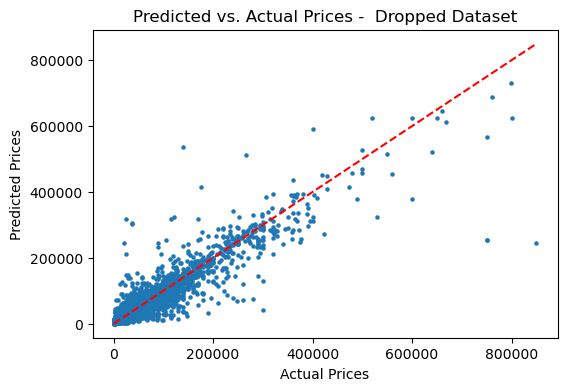

In [35]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, s=5)  # Correctly plot inverse transformed values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices -  Dropped Dataset')
plt.show()

### In this dataset I will remove the outliers:

In [20]:
# Remove outliers using Z-score for price and mileage
df_clean = df[(np.abs(stats.zscore(df['price_in_euro'])) < 4)]  # 3 is the standard threshold for outliersb
df_clean = df_clean[(np.abs(stats.zscore(df_clean['mileage_in_km'])) < 4)]  # Do the same for mi


X = df_clean.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df_clean['price_in_euro']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211721 entries, 0 to 213735
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   brand                             211721 non-null  object 
 1   model                             211721 non-null  object 
 2   price_in_euro                     211721 non-null  float64
 3   power_ps                          211721 non-null  float64
 4   fuel_consumption_l_100km          211721 non-null  float64
 5   mileage_in_km                     211721 non-null  float64
 6   age                               211721 non-null  float64
 7   Modell_encoded                    211721 non-null  float64
 8   Brand_encoded                     211721 non-null  float64
 9   fuel_type_CNG                     211721 non-null  int64  
 10  fuel_type_Diesel                  211721 non-null  int64  
 11  fuel_type_Diesel Hybrid           211721 non-null  int64 

In [22]:
# Define custom transformations
log_transformer = FunctionTransformer(np.log1p, validate=True)  # Log(x + 1) to avoid log(0) issue
sqrt_transformer = FunctionTransformer(np.sqrt, validate=True)

# List of columns to apply transformations
log_columns = ['age', 'power_ps', 'Modell_encoded', 'Brand_encoded', 'fuel_consumption_l_100km']  # Columns that need log transformation
sqrt_columns = ['mileage_in_km']  # Square root transformation for mileage
robust_columns = ['age', 'power_ps', 'Modell_encoded', 'Brand_encoded', 'fuel_consumption_l_100km', 'mileage_in_km']  # Robust scaling for K-NN (price included)

# Preprocessing pipelines for specific models
knn_preprocessor = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), robust_columns)
    ], remainder='passthrough')

linreg_preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', log_transformer, log_columns),
        ('sqrt_transform', sqrt_transformer, sqrt_columns)
    ], remainder='passthrough')

# For Random Forest and Decision Tree, we can skip preprocessing


# Define the full pipeline with different models
pipeline = Pipeline([
    ('preprocessor', 'passthrough'),  # Placeholder for model-specific preprocessing
    ('regressor', RandomForestRegressor())  # Placeholder for the model
])

# Set up the parameter grid with model-specific preprocessing pipelines
param_grid = [
    {
        'preprocessor': [linreg_preprocessor],
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False],
    },
    {
        'preprocessor': [knn_preprocessor],
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': [3, 5, 7],
    },
    {
        'preprocessor': ['passthrough'],  # No preprocessing for Random Forest
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
    },
    {
        'preprocessor': ['passthrough'],  # No preprocessing for Decision Tree
        'regressor': [DecisionTreeRegressor()],
        'regressor__max_depth': [10, 20, None],
    },
     {
        'preprocessor': ['passthrough'],  # No preprocessing for XGBoost
        'regressor': [XGBRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [5, 10, 15],
        'regressor__learning_rate': [0.01, 0.1, 0.3],
        'regressor__subsample': [0.8, 1.0],
    }
]

# Perform GridSearchCV over the pipeline with different models and preprocessing
grid_search_5 = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_5.fit(X_train, y_train)

# Find the best model and hyperparametersb
print("Best model and hyperparameters: ", grid_search_5.best_params_)

/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model and hyperparameters:  {'preprocessor': 'passthrough', 'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}


In [23]:
# Get all the results into a DataFrame
results_5 = pd.DataFrame(grid_search_5.cv_results_)

# Display the entire results DataFrame
#print(results)

# If you want to sort by mean test score for better visibility
sorted_results_5 = results_5.sort_values(by='mean_test_score', ascending=False)
sorted_results_5[['param_regressor', 'param_regressor__fit_intercept', 
                      'param_regressor__n_neighbors', 'param_regressor__n_estimators', 
                      'param_regressor__max_depth', 'mean_test_score']]

,param_regressor,param_regressor__fit_intercept,param_regressor__n_neighbors,param_regressor__n_estimators,param_regressor__max_depth,mean_test_score
30,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,100,10,0.907392
33,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,10,0.907213
31,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,100,10,0.907193
32,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,10,0.907112
8,RandomForestRegressor(),NaN,NaN,200,20,0.905324
7,RandomForestRegressor(),NaN,NaN,100,20,0.905056
10,RandomForestRegressor(),NaN,NaN,200,None,0.904827
9,RandomForestRegressor(),NaN,NaN,100,None,0.904346
41,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,200,5,0.903938
43,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,100,10,0.902157


In [24]:
# Get the best cross-validated score (MSE or whatever scoring metric you used)
best_cv_score_5 = grid_search_5.best_score_
print(f"Best Cross-Validated Score (r2 score): {best_cv_score_5}")

# Get the best hyperparameters and model
best_params_5 = grid_search_5.best_params_
best_model_5 = grid_search_5.best_estimator_

print("Best Hyperparameters: ", best_params_5)

Best Cross-Validated Score (r2 score): 0.9073918754061852
Best Hyperparameters:  {'preprocessor': 'passthrough', 'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}


In [25]:
# Predict on the test set
y_pred = best_model_5.predict(X_test)


mse_test_5 = mean_squared_error(y_test, y_pred)
mae_test_5 = mean_absolute_error(y_test, y_pred)
r2_test_5 = r2_score(y_test, y_pred)

print(f"Test Set MSE: {mse_test_5}")
print(f"Test Set MAE: {mae_test_5}")
print(f"Test Set R²: {r2_test_5}")

Test Set MSE: 31503649.623881664
Test Set MAE: 2771.62272486104
Test Set R²: 0.9118749746692717


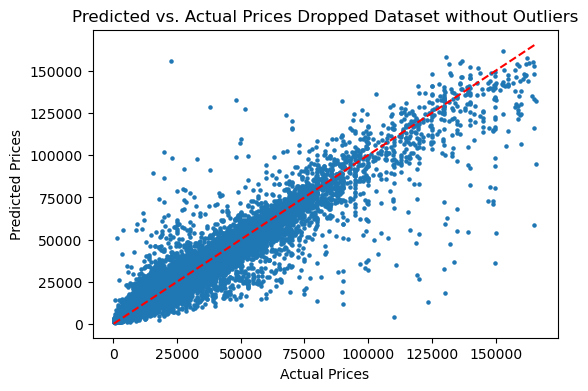

In [26]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, s=5)  # Correctly plot inverse transformed values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices Dropped Dataset without Outliers')
plt.show()

## Choosing the best model 

In [44]:
# Get the best cross-validated score (MSE or whatever scoring metric you used)
best_cv_score = grid_search.best_score_
print(f"Full dataset - Best Cross-Validated Score (r2 score): {best_cv_score}")

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters for full dataset : ", best_params)

# Get the best cross-validated score (MSE or whatever scoring metric you used)
best_cv_score_3 = grid_search_3.best_score_
print(f"Full dataset withput outliers - Best Cross-Validated Score (r2 score): {best_cv_score_3}")

# Get the best hyperparameters and model
best_params_3 = grid_search_3.best_params_
best_model_3 = grid_search_3.best_estimator_

print("Best Hyperparameters - Full dataset without outliers: ", best_params_3)

# Get the best cross-validated score (MSE or whatever scoring metric you used)
best_cv_score_4 = grid_search_4.best_score_
print(f"Dropped dataset - Best Cross-Validated Score (r2 score): {best_cv_score_4}")

# Get the best hyperparameters and model
best_params_4 = grid_search_4.best_params_
best_model_4 = grid_search_4.best_estimator_

print("Best Hyperparameters - Dropped dataset: ", best_params_4)

# Get the best cross-validated score (MSE or whatever scoring metric you used)
best_cv_score_5 = grid_search_5.best_score_
print(f"Dropped dataset without outliers - Best Cross-Validated Score (r2 score): {best_cv_score_5}")

# Get the best hyperparameters and model
best_params_5 = grid_search_5.best_params_
best_model_5 = grid_search_5.best_estimator_

print("Best Hyperparameters - Dropped dataset withput outliers: ", best_params_5)

Full dataset - Best Cross-Validated Score (r2 score): 0.803790824557552
Best Hyperparameters for full dataset :  {'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('robust_scaler', RobustScaler(),
                                 ['age', 'power_ps', 'Modell_encoded',
                                  'Brand_encoded', 'fuel_consumption_l_100km',
                                  'mileage_in_km'])]), 'regressor': KNeighborsRegressor(n_neighbors=3), 'regressor__n_neighbors': 3}
Full dataset withput outliers - Best Cross-Validated Score (r2 score): 0.9071182147967513
Best Hyperparameters - Full dataset without outliers:  {'preprocessor': 'passthrough', 'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             g

In [27]:
# Data to populate the DataFrame
data = {
    'Best Estimator': [
        'KNeighborsRegressor',
        'XGBRegressor',
        'KNeighborsRegressor',
        'XGBRegressor'
    ],
    'n_estimators': [
        'NA',
        200,
        'NA',
        100
    ],
    'max_depth':[
        'NA',
        20,
        'NA',
        10
    ], 
    'n_neighbors':[
        3,
        'NA',
        3,
        'NA'
    ], 
    'learning_rate':[
        'NA',
        0.1,
        'NA',
        0.1
    ],
    
    'Score': [
        0.803,
        0.9107,
        0.76,
        0.907
    ],
    'MAE':[4110, 2790, 3956, 2771],
    'MSE': [172252763, 33357651, 115936049, 31503649]
}

# Creating index for the DataFrame
index = [
    'Full dataset', 
    'Full dataset without outliers', 
    'Dropped dataset', 
    'Dropped dataset without outliers'
]

# Creating the DataFrame
best_models = pd.DataFrame(data, index=index)

# Display the DataFrame
best_models

,Best Estimator,n_estimators,max_depth,n_neighbors,learning_rate,Score,MAE,MSE
Full dataset,KNeighborsRegressor,NA,NA,3,NA,0.8030,4110,172252763
Full dataset without outliers,XGBRegressor,200,20,NA,0.1,0.9107,2790,33357651
Dropped dataset,KNeighborsRegressor,NA,NA,3,NA,0.7600,3956,115936049
Dropped dataset without outliers,XGBRegressor,100,10,NA,0.1,0.9070,2771,31503649
